In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.special import softmax
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv('Potato-Prolific-Dataset-main/dataset/offensiveness/raw_data.csv')
df = df[df['race'] == 'White'][['text', 'offensiveness']].copy()
df = df.dropna(subset=['text','offensiveness'])
df['offensiveness'] = df['offensiveness'].astype(int)
df['labels'] = (df['offensiveness'] > 1).astype(int)

from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['labels'], random_state=42
)
test_texts = test_df['text'].tolist()
test_labels = test_df['labels'].values


In [ ]:
ensemble_models = [
    # RoBERTa 5
    ('roberta1', 'roberta-base', 'models/roberta_binary_seed42.bin'),
    ('roberta2', 'roberta-base', 'models/roberta_binary_seed128.bin'),
    ('roberta3', 'roberta-base', 'models/roberta_binary_seed256.bin'),
    ('roberta4', 'roberta-base', 'models/roberta_binary_seed512.bin'),
    ('roberta5', 'roberta-base', 'models/roberta_binary_seed2025.bin'),
    # BERT 5
    ('bert1', 'bert-base-uncased', 'models/bert_seed42.bin'),
    ('bert2', 'bert-base-uncased', 'models/bert_seed128.bin'),
    ('bert3', 'bert-base-uncased', 'models/bert_seed256.bin'),
    ('bert4', 'bert-base-uncased', 'models/bert_seed1024.bin'),
    ('bert5', 'bert-base-uncased', 'models/bert_seed2025.bin'),
]
NUM_LABELS = 2
MAX_LENGTH = 128
BATCH_SIZE = 16


In [ ]:
all_logits = []  
model_names = [] 

for (model_id, pretrained, ckpt) in ensemble_models:
    print(f"Predicting with {model_id} ({pretrained}) ...")
    tokenizer = AutoTokenizer.from_pretrained(pretrained)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained, num_labels=NUM_LABELS)
    checkpoint = torch.load(ckpt, map_location=device)
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.eval()
    model.to(device)

    logits_list = []
    with torch.no_grad():
        for i in tqdm(range(0, len(test_texts), BATCH_SIZE)):
            batch_text = test_texts[i:i+BATCH_SIZE]
            encoded = tokenizer(
                batch_text,
                padding='max_length',
                truncation=True,
                max_length=MAX_LENGTH,
                return_tensors='pt'
            )
            for k in encoded:
                encoded[k] = encoded[k].to(device)
            with torch.cuda.amp.autocast(enabled=False):
                out = model(**encoded)
                batch_logits = out.logits.cpu().numpy()
            logits_list.append(batch_logits)
    model_preds = np.concatenate(logits_list, axis=0)
    all_logits.append(model_preds)
    model_names.append(model_id)
    del model; torch.cuda.empty_cache()
print("All models predicted.")


Predicting with roberta1 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\34800\AppData\Local\Temp\ipykernel_15428\3784427017.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode un

Predicting with roberta2 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:14<00:00,  8.29it/s]


Predicting with roberta3 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:15<00:00,  7.84it/s]


Predicting with roberta4 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:21<00:00,  5.81it/s]


Predicting with roberta5 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:17<00:00,  6.87it/s]


Predicting with bert1 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:17<00:00,  7.05it/s]


Predicting with bert2 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:17<00:00,  6.95it/s]


Predicting with bert3 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:17<00:00,  6.98it/s]


Predicting with bert4 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:20<00:00,  6.09it/s]


Predicting with bert5 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 123/123 [00:21<00:00,  5.74it/s]

All models predicted.


In [ ]:
for i, name in enumerate(model_names):
    pred = all_logits[i].argmax(axis=1)
    print(f"\n=== Single Model {name} ===\n")
    print(classification_report(test_labels, pred, digits=4))

roberta_idx = [i for i,name in enumerate(model_names) if name.startswith('roberta')]
if roberta_idx:
    probs_roberta = [softmax(all_logits[i], axis=1) for i in roberta_idx]
    roberta_avgp = np.mean(probs_roberta,axis=0)
    r_pred = np.argmax(roberta_avgp, axis=1)
    print("\n=== All RoBERTa (soft vote ensemble) ===\n")
    print(classification_report(test_labels, r_pred, digits=4))

bert_idx = [i for i,name in enumerate(model_names) if name.startswith('bert')]
if bert_idx:
    probs_bert = [softmax(all_logits[i], axis=1) for i in bert_idx]
    bert_avgp = np.mean(probs_bert,axis=0)
    b_pred = np.argmax(bert_avgp, axis=1)
    print("\n=== All BERT (soft vote ensemble) ===\n")
    print(classification_report(test_labels, b_pred, digits=4))

probs_list = [softmax(x, axis=1) for x in all_logits]
avg_probs = np.mean(probs_list, axis=0)
soft_preds = np.argmax(avg_probs, axis=1)
print("\n=== ALL models Soft Voting ===\n")
print(classification_report(test_labels, soft_preds, digits=4))

hard_preds_list = [np.argmax(x, axis=1) for x in all_logits]
hard_mat = np.stack(hard_preds_list, axis=0)
hard_preds = mode(hard_mat, axis=0).mode.squeeze()
print("\n=== ALL models Hard Voting ===\n")
print(classification_report(test_labels, hard_preds, digits=4))



=== Single Model roberta1 ===

              precision    recall  f1-score   support

           0     0.7517    0.6702    0.7086      1134
           1     0.6063    0.6965    0.6483       827

    accuracy                         0.6813      1961
   macro avg     0.6790    0.6833    0.6785      1961
weighted avg     0.6904    0.6813    0.6832      1961


=== Single Model roberta2 ===

              precision    recall  f1-score   support

           0     0.7705    0.7284    0.7489      1134
           1     0.6535    0.7025    0.6772       827

    accuracy                         0.7175      1961
   macro avg     0.7120    0.7155    0.7130      1961
weighted avg     0.7212    0.7175    0.7186      1961


=== Single Model roberta3 ===

              precision    recall  f1-score   support

           0     0.7624    0.7302    0.7459      1134
           1     0.6503    0.6880    0.6686       827

    accuracy                         0.7124      1961
   macro avg     0.7064    0.709

C:\Users\34800\AppData\Local\Temp\ipykernel_15428\1033153860.py:35: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  hard_preds = mode(hard_mat, axis=0).mode.squeeze()


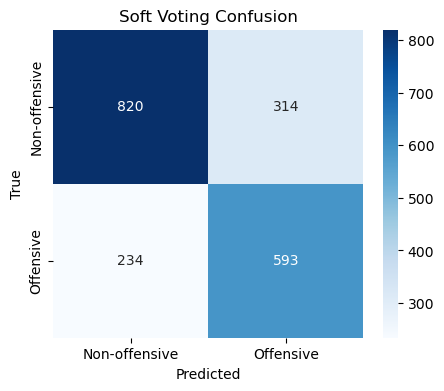

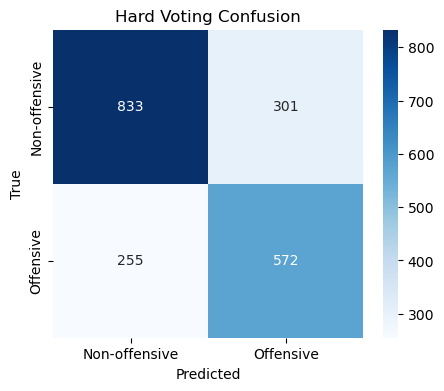

In [5]:
def plot_conf_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_conf_matrix(test_labels, soft_preds, class_names=["Non-offensive", "Offensive"], title="Soft Voting Confusion")
plot_conf_matrix(test_labels, hard_preds, class_names=["Non-offensive", "Offensive"], title="Hard Voting Confusion")
